In [1]:
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import yfinance
from vangja.components import LinearTrend, FourierSeasonality, Constant

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

Importing plotly failed. Interactive plots will not work.


# Data fetcher

In [2]:
indexes = ["^W5000", "^GSPC", "^IXIC", "^DJI"]

gspc_tickers = [
    "AAPL", "MSFT", "AMZN", "FB", "TSLA", "GOOGL", "GOOG", "JNJ", "JPM", "V",
    "PG", "UNH", "DIS", "NVDA", "MA", "HD", "PYPL", "VZ", "ADBE", "CMCSA",
    "NFLX", "BAC", "KO", "MRK", "PEP", "T", "PFE", "INTC", "CRM", "WMT", "ABT",
    "ABBV", "CSCO", "TMO", "NKE", "AVGO", "XOM", "QCOM", "COST", "ACN", "CVX",
    "MCD", "MDT", "NEE", "TXN", "HON", "DHR", "UNP", "BMY", "LIN", "LLY",
    "AMGN", "PM", "C", "SBUX", "WFC", "ORCL", "UPS", "LOW", "BA", "IBM", "AMD",
    "RTX", "NOW", "BLK", "MMM", "INTU", "AMT", "CAT", "MS", "CHTR", "ISRG",
    "GE", "BKNG", "GS", "CVS", "TGT", "FIS", "LMT", "DE", "MU", "MDLZ", "TJX",
    "SYK", "ANTM", "SCHW", "SPGI", "AXP", "AMAT", "TMUS", "ZTS", "MO", "ADP",
    "CI", "PLD", "CL", "GILD", "BDX", "ATVI", "CB", "CSX", "CCI", "LRCX",
    "DUK", "ADSK", "FISV", "CME", "SO", "ICE", "TFC", "GPN", "USB", "EQIX",
    "PNC", "FDX", "VRTX", "D", "APD", "NSC", "EL", "SHW", "MMC", "ITW", "PGR",
    "EW", "ADI", "HUM", "ILMN", "ECL", "GM", "DD", "DG", "BSX", "REGN", "AON",
    "NEM", "EMR", "ETN", "NOC", "MCO", "KMB", "WM", "COF", "ROP", "CTSH",
    "ROST", "HCA", "TWTR", "COP", "IDXX", "EA", "AEP", "EXC", "DOW", "BAX",
    "TEL", "KLAC", "LHX", "SNPS", "APH", "DLR", "CMG", "ALGN", "CDNS", "SYY",
    "FCX", "BIIB", "STZ", "MSCI", "SRE", "A", "MCHP", "GIS", "MET", "TRV",
    "DXCM", "APTV", "PSA", "PH", "MAR", "XEL", "TT", "CNC", "XLNX", "GD", "BK",
    "F", "IQV", "TROW", "ALXN", "MNST", "PPG", "HPQ", "VRSK", "JCI", "TDG",
    "CMI", "INFO", "ALL", "EBAY", "ORLY", "YUM", "AIG", "ZBH", "SBAC", "ANSS",
    "CTAS", "PRU", "HLT", "RMD", "CARR", "PSX", "BLL", "SLB", "PCAR", "PAYX",
    "ES", "PEG", "ROK", "EOG", "AFL", "WEC", "CTVA", "MSI", "WBA", "SWK",
    "ADM", "FAST", "SPG", "MCK", "AME", "AWK", "DFS", "LUV", "OTIS", "GLW",
    "AZO", "VFC", "WLTW", "MTD", "WELL", "MPC", "KMI", "CPRT", "STT", "DAL",
    "FRC", "CLX", "DLTR", "SWKS", "WY", "ED", "KR", "KEYS", "WMB", "CERN",
    "TTWO", "FTV", "AJG", "EIX", "MKC", "MXIM", "LYB", "DTE", "EFX", "VLO",
    "BBY", "AMP", "DHI", "FLT", "VTRS", "HSY", "KHC", "AVB", "PAYC", "ETSY",
    "O", "VRSN", "PPL", "CHD", "MKTX", "ARE", "VIAC", "CBRE", "LEN", "WST",
    "ZBRA", "EQR", "RSG", "SIVB", "FTNT", "ETR", "TER", "LH", "VMC", "FITB",
    "LVS", "IP", "NTRS", "AEE", "TFX", "KSU", "QRVO", "TSN", "SYF", "CDW",
    "ODFL", "PXD", "HOLX", "AMCR", "GWW", "VTR", "XYL", "DOV", "EXPE", "GRMN",
    "COO", "CAG", "BR", "MLM", "TYL", "HIG", "CMS", "CTLT", "AKAM", "OKE",
    "IR", "WDC", "URI", "HAL", "FE", "TSCO", "MTB", "PEAK", "INCY", "ULTA",
    "STE", "CCL", "EXPD", "PKI", "NUE", "DGX", "KEY", "CTXS", "VAR", "K",
    "ANET", "CAH", "ALB", "AES", "DRI", "KMX", "RF", "ESS", "WAT", "CFG",
    "HPE", "NDAQ", "CE", "DPZ", "IEX", "EXR", "POOL", "FMC", "DRE", "NTAP",
    "ABMD", "OXY", "MAA", "GPC", "TDY", "HES", "ABC", "MAS", "IT", "NVR",
    "TIF", "J", "LDOS", "BKR", "STX", "RCL", "EMN", "OMC", "BXP", "SJM", "WAB",
    "HRL", "PKG", "CINF", "AVY", "MGM", "LNT", "HBAN", "CHRW", "PFG", "UAL",
    "EVRG", "BIO", "JKHY", "NLOK", "HAS", "ATO", "FBHS", "CNP", "RJF", "IFF",
    "PHM", "LW", "CXO", "XRAY", "WRK", "JBHT", "UDR", "WHR", "HWM", "TXT",
    "WYNN", "FFIV", "ALLE", "AAP", "UHS", "L", "LYV", "HST", "CBOE", "PWR",
    "LKQ", "FOXA", "CPB", "AAL", "LUMN", "HSIC", "BWA", "RE", "WRB", "SNA",
    "IPG", "NRG", "GL", "LNC", "WU", "PNW", "PNR", "NI", "LB", "DVA", "ROL",
    "TPR", "TAP", "IRM", "MHK", "CF", "AIZ", "NCLH", "NWL", "DISH", "IPGP",
    "MOS", "CMA", "DISCK", "FANG", "NLSN", "AOS", "JNPR", "REG", "ZION", "RHI",
    "SEE", "NWSA", "HII", "BEN", "PVH", "IVZ", "DXC", "COG", "KIM", "ALK",
    "PRGO", "DVN", "LEG", "FRT", "VNO", "FLIR", "PBCT", "APA", "NOV", "MRO",
    "HBI", "RL", "DISCA", "FLS", "UNM", "VNT", "FOX", "SLG", "GPS", "FTI",
    "XRX", "HFC", "UAA", "UA", "NWS"
]

dji_tickers = [
    "DIS", "WMT", "DOW", "NKE", "CRM", "HD", "V", "MSFT", "MMM", "CSCO", "KO",
    "AAPL", "HON", "JNJ", "TRV", "PG", "CVX", "VZ", "CAT", "BA", "AMGN", "IBM",
    "AXP", "JPM", "WBA", "MCD", "MRK", "GS", "UNH", "INTC"
]

ixic_tickers = [
    "FEYE", "ATEC", "SLAB", "CMRX", "NVCR", "FNLC", "NMRK", "SCOR", "AGLE",
    "FARO", "OLMA", "TSLA", "FRTA", "AKTX", "KLXE", "CVCO", "NVCN", "EXAS",
    "SDC", "BBQ", "IFRX", "CIIC", "BBI", "FNKO", "TWST", "FARM", "ACCD",
    "NMRD", "FRSX", "OPTT"
]

In [3]:
def fetch_data(tickers, start="1970-01-01", end="2020-01-01"):
    data = yfinance.download(
        tickers,
        interval="1d",
        start=start,
        end=end,
    )
    downloaded_tickers = {col[1] for col in data.columns}
    dfs = []
    for ticker in downloaded_tickers:
        df = pd.DataFrame(
            data={
                "open": data["Open"][ticker].to_numpy(),
                "high": data["High"][ticker].to_numpy(),
                "low": data["Low"][ticker].to_numpy(),
                "close": data["Close"][ticker].to_numpy(),
                "typical_price": (
                    (
                        data["Open"][ticker]
                        + data["High"][ticker]
                        + data["Low"][ticker]
                        + data["Close"][ticker]
                    )
                    / 4
                ).to_numpy(),
                "volume": data["Volume"][ticker].to_numpy(),
            },
            index=data["Close"][ticker].index,
        )

        full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")
        df = df.reindex(full_date_range).interpolate()
        df["ds"] = df.index
        df.reset_index(drop=True, inplace=True)
        df["series"] = ticker
        dfs.append(df)

    return dfs

In [4]:
def generate_train_test_df(
    start,
    window,
    horizon,
    dfs,
    for_prophet=False,
    y_col="typical_price",
    perform_scaling=True,
):
    train_dfs = []
    test_dfs = []
    scales = []
    for df in dfs:
        train_df = df[start : start + window].copy()
        test_df = df[start + window : start + window + horizon].copy()
        if train_df.isna().any().any() or test_df.isna().any().any():
            continue

        train_df["y"] = train_df[y_col]
        test_df["y"] = test_df[y_col]

        if perform_scaling:
            scales.append(train_df[y_col].max())
            train_df["y"] = train_df[y_col] / scales[-1]
            test_df["y"] = test_df[y_col] / scales[-1]

        train_dfs.append(train_df)
        test_dfs.append(test_df)

    if len(train_dfs) == 0:
        return None

    if for_prophet:
        return train_dfs, test_dfs, scales

    return pd.concat(train_dfs), pd.concat(test_dfs), scales

In [5]:
def generate_train_test_df_around_point(
    window,
    horizon,
    dfs,
    point="2009-09-01",
    for_prophet=False,
    y_col="typical_price",
    perform_scaling=True,
):
    train_dfs = []
    test_dfs = []
    scales = []

    for df in dfs:
        point_idx = len(df[df["ds"] < point])
        check = generate_train_test_df(
            start=point_idx - window,
            window=window,
            horizon=horizon,
            dfs=[df],
            for_prophet=for_prophet,
            y_col=y_col,
            perform_scaling=perform_scaling,
        )
        if check is None:
            continue

        train_df, test_df, scale = check

        scales += scale

        if for_prophet:
            train_dfs += train_df
            test_dfs += test_df
        else:
            train_dfs.append(train_df)
            test_dfs.append(test_df)

    if len(train_dfs) == 0:
        return None
    
    if for_prophet:
        return train_dfs, test_dfs, scales
    
    return pd.concat(train_dfs), pd.concat(test_dfs), scales

# Generate models

In [89]:
# model_components = [
#     [LinearTrend(pool_cols="series", pool_type=pt) for pt in ["individual", "partial"]],
#     [
#         FourierSeasonality(
#             period=365.25, series_order=10, pool_cols="series", pool_type=pt
#         )
#         for pt in ["individual", "partial"]
#     ],
#     [
#         FourierSeasonality(
#             period=91.3125, series_order=n, pool_cols="series", pool_type=pt
#         )
#         for n in range(7, 10)
#         for pt in ["individual", "partial"]
#     ],
#     [
#         FourierSeasonality(
#             period=30.4375, series_order=n, pool_cols="series", pool_type=pt
#         )
#         for n in range(4, 7)
#         for pt in ["individual", "partial"]
#     ],
#     [
#         FourierSeasonality(period=7, series_order=3, pool_cols="series", pool_type=pt)
#         for pt in ["individual", "partial"]
#     ],
# ]

model_components = [
    [LinearTrend(allow_tune=False)],
    [
        FourierSeasonality(period=365.25, series_order=10, allow_tune=allow_tune)
        for allow_tune in [True]
    ],
    # [
    #     FourierSeasonality(period=91.3125, series_order=n, allow_tune=allow_tune)
    #     for n in range(7, 10)
    #     for allow_tune in [True, False]
    # ],
    # [
    #     FourierSeasonality(period=30.4375, series_order=n, allow_tune=allow_tune)
    #     for n in range(4, 7)
    #     for allow_tune in [True, False]
    # ],
    [
        FourierSeasonality(period=7, series_order=3, allow_tune=allow_tune)
        for allow_tune in [True, False]
    ],
]

# model_components = [
#     [LinearTrend(allow_tune=False, pool_cols="series", pool_type="individual")],
#     [
#         FourierSeasonality(
#             period=365.25,
#             series_order=10,
#             allow_tune=allow_tune,
#             pool_cols="series",
#             pool_type="individual",
#         )
#         for allow_tune in [True]
#     ],
#     # [
#     #     FourierSeasonality(
#     #         period=91.3125,
#     #         series_order=n,
#     #         allow_tune=allow_tune,
#     #         pool_cols="series",
#     #         pool_type="individual",
#     #     )
#     #     for n in range(7, 10)
#     #     for allow_tune in [True, False]
#     # ],
#     # [
#     #     FourierSeasonality(
#     #         period=30.4375,
#     #         series_order=n,
#     #         allow_tune=allow_tune,
#     #         pool_cols="series",
#     #         pool_type="individual",
#     #     )
#     #     for n in range(4, 7)
#     #     for allow_tune in [True, False]
#     # ],
#     [
#         FourierSeasonality(
#             period=7,
#             series_order=3,
#             allow_tune=allow_tune,
#             pool_cols="series",
#             pool_type="individual",
#         )
#         for allow_tune in [True, False]
#     ],
# ]

In [90]:
q = [(0, [mc]) for mc in model_components[0]]
models = []

while len(q):
    level, model = q.pop(0)
    if level + 1 == len(model_components):
        models.append(model)
        continue

    mcs = model_components[level + 1]
    for mc in mcs:
        # if mc.pool_type == "partial":
        #     q.append(
        #         (
        #             level + 1,
        #             model
        #             + [
        #                 Constant(
        #                     lower=-1, upper=1, pool_cols="series", pool_type="partial"
        #                 )
        #                 * mc
        #             ],
        #         )
        #     )

        q.append((level + 1, model + [mc]))
        q.append((level + 1, model))

In [91]:
def sum_models(models):
    s = None
    for model in models:
        if s is None:
            s = model
        else:
            s += model

    return s

In [92]:
models = (
    [
        LinearTrend() * (FourierSeasonality(365.25, 10) + FourierSeasonality(7, 3)),
        LinearTrend() * FourierSeasonality(365.25, 10),
        LinearTrend() * FourierSeasonality(7, 3),
        LinearTrend() + FourierSeasonality(365.25, 10) + FourierSeasonality(7, 3),
        LinearTrend() + FourierSeasonality(365.25, 10),
        LinearTrend() + FourierSeasonality(7, 3),
    ]
    + [
        model[0] * sum_models(model[1:]) if len(model) > 1 else model[0]
        for model in models
    ]
    + [sum_models(model) if len(model) > 1 else model[0] for model in models]
)

In [93]:
str_models = {""}
final_models = []
for model in models:
    str_model = str(model)
    if str_model in str_models:
        continue

    str_models.add(str_model)
    final_models.append(model)

len(final_models)

15

In [94]:
str_models

{'',
 'LT(n=25,r=0.8,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=False,complete) + FS(p=7,n=3,at=False,complete))',
 'LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete))',
 'LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=True,complete))',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=True,complete)',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=True,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=False,complete) + FS(p=7,n=3,at=False,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete)',
 'LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=Fals

# Test prophet

In [6]:
def get_prophet_metrics(y_trues, y_preds, horizon):
    result = None
    for y_true, y_pred in zip(y_trues, y_preds):
        group_name = y_true["series"].iloc[0]
        single_metrics = {"mse": {}, "rmse": {}, "mae": {}, "mape": {}}
        single_metrics["mse"][group_name] = mean_squared_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["rmse"][group_name] = root_mean_squared_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["mae"][group_name] = mean_absolute_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        single_metrics["mape"][group_name] = mean_absolute_percentage_error(
            y_true["y"], y_pred["yhat"][-horizon:]
        )
        if result is None:
            result = pd.DataFrame(single_metrics)
        else:
            result = pd.concat((result, pd.DataFrame(single_metrics)))

    return result

In [7]:
smp = fetch_data(["^GSPC"])
smp_tickers = fetch_data(gspc_tickers, start="2000-01-01", end="2011-01-01")

[*********************100%***********************]  1 of 1 completed
[**********            20%                       ]  100 of 503 completedFailed to get ticker 'ANTM' reason: Expecting value: line 1 column 1 (char 0)
[**********************60%****                   ]  303 of 503 completedFailed to get ticker 'SIVB' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  503 of 503 completed

87 Failed downloads:
['TWTR', 'DISCK', 'KSU', 'CXO', 'FB', 'PBCT', 'ANTM', 'FLT', 'XLNX', 'MXIM', 'VIAC', 'WRK', 'DISH', 'PEAK', 'NLOK', 'PXD', 'ATVI', 'DISCA', 'BLL', 'SIVB', 'FRC', 'TIF', 'COG', 'NLSN', 'CERN', 'FBHS', 'DRE', 'GPS', 'FLIR', 'HFC', 'RE', 'VAR', 'ABC', 'ABMD', 'PKI', 'CTXS', 'WLTW', 'ALXN']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['LW', 'HOLX', 'INTC', 'CSX', 'AEE', 'UA', 'CTLT', 'PSX', 'DOW', 'FOXA']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
['FTV', 'FOX', 'APTV', 'PYPL', 'ALLE', 'KMI'

In [112]:
crisis_tickers = smp + [t for t in smp_tickers if t["series"].iloc[0] in seven_index]
len(crisis_tickers), len(seven_index.to_list())

(385, 385)

In [114]:
point = "2007-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 35, horizon=365, dfs=smp, for_prophet=True, point=point
)
train_df_ticker, test_df_tickers, scales_tickers = generate_train_test_df_around_point(
    window=365 * 1, horizon=365, dfs=crisis_tickers, for_prophet=True, point=point
)

In [115]:
train_df_ticker[0]

,open,high,low,close,typical_price,volume,ds,series,y
13148,1251.355042,1262.320007,1246.164978,1258.545044,1254.596268,1.999035e+09,2006-01-01,^GSPC,0.878926
13149,1249.822540,1266.269989,1245.952484,1263.672546,1256.429390,2.276802e+09,2006-01-02,^GSPC,0.880210
13150,1248.290039,1270.219971,1245.739990,1268.800049,1258.262512,2.554570e+09,2006-01-03,^GSPC,0.881494
13151,1268.800049,1275.369995,1267.739990,1273.459961,1271.342499,2.515330e+09,2006-01-04,^GSPC,0.890658
13152,1273.459961,1276.910034,1270.300049,1273.479980,1273.537506,2.433340e+09,2006-01-05,^GSPC,0.892195
...,...,...,...,...,...,...,...,...,...
13508,1416.630005,1427.719971,1416.630005,1426.839966,1421.954987,1.667370e+09,2006-12-27,^GSPC,0.996171
13509,1426.770020,1427.260010,1422.050049,1424.729980,1425.202515,1.508570e+09,2006-12-28,^GSPC,0.998447
13510,1424.709961,1427.000000,1416.839966,1418.300049,1421.712494,1.678200e+09,2006-12-29,^GSPC,0.996002
13511,1423.373975,1427.484009,1415.043970,1417.960034,1420.965497,2.028392e+09,2006-12-30,^GSPC,0.995478


In [16]:
context_prophet = Prophet(seasonality_mode="multiplicative")
context_prophet.fit(train_df_smp[0])
context_future = context_prophet.make_future_dataframe(
    periods=365, include_history=True
)
context_yhat = context_prophet.predict(context_future)
context_metrics = get_prophet_metrics(test_df_smp, [context_yhat], 365)
context_metrics

,mse,rmse,mae,mape
^GSPC,0.034712,0.186312,0.181553,0.210649


In [119]:
prophet_forecasts = []

for df, df_test in tqdm(zip(train_df_ticker, test_df_tickers)):
    prophet = Prophet(seasonality_mode="additive")
    # prophet.add_regressor("smp_weekly", standardize=False, mode="additive")
    # prophet.add_regressor("smp_yearly", standardize=False, mode="additive")
    # prophet.add_regressor("smp_yhat", standardize=False, mode="additive")

    train_df = df.copy()
    # train_df["smp_weekly"] = context_yhat[
    #     (context_yhat["ds"] >= train_df["ds"].iloc[0])
    #     & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
    # ]["weekly"].to_numpy()
    # train_df["smp_yhat"] = context_yhat[
    #     (context_yhat["ds"] >= train_df["ds"].iloc[0])
    #     & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
    # ]["yhat"].to_numpy()
    # train_df["smp_yearly"] = context_yhat[
    #     (context_yhat["ds"] >= train_df["ds"].iloc[0])
    #     & (context_yhat["ds"] <= train_df["ds"].iloc[-1])
    # ]["yearly"].to_numpy()

    prophet.fit(train_df)

    future = prophet.make_future_dataframe(periods=365, include_history=True)
    # future["smp_weekly"] = context_yhat[
    #     (context_yhat["ds"] >= future["ds"].iloc[0])
    #     & (context_yhat["ds"] <= future["ds"].iloc[-1])
    # ]["weekly"].to_numpy()
    # future["smp_yhat"] = context_yhat[
    #     (context_yhat["ds"] >= future["ds"].iloc[0])
    #     & (context_yhat["ds"] <= future["ds"].iloc[-1])
    # ]["yhat"].to_numpy()
    # future["smp_yearly"] = context_yhat[
    #     (context_yhat["ds"] >= future["ds"].iloc[0])
    #     & (context_yhat["ds"] <= future["ds"].iloc[-1])
    # ]["yearly"].to_numpy()

    prophet_forecasts.append(prophet.predict(future))

prophet_metrics = get_prophet_metrics(test_df_tickers, prophet_forecasts, 365)
prophet_metrics["mape"].mean()

385it [01:55,  3.32it/s]


0.22096334022526398

In [25]:
prophet_metrics

,mse,rmse,mae,mape
^GSPC,0.030368,0.174264,0.156164,0.150546
KR,0.070413,0.265355,0.226613,0.209672
TYL,0.012696,0.112678,0.089243,0.064205
WAB,0.035217,0.187662,0.154660,0.130060
CTSH,0.005304,0.072825,0.060088,0.047373
...,...,...,...,...
DD,0.032943,0.181503,0.166658,0.227767
IP,0.300409,0.548096,0.482266,0.571892
CCI,0.014618,0.120904,0.093315,0.079542
RF,0.077427,0.278258,0.249598,0.234854


# Test model

In [95]:
def run_test(idx, point):
    train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
        window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
    )
    model = final_models[idx]
    model.fit(train_df_smp, progressbar=False)
    map_approx = model.map_approx
    model_metrics = []

    for smp_ticker in tqdm(smp + smp_tickers):
        check = generate_train_test_df_around_point(
            window=365 * 1,
            horizon=365,
            dfs=[smp_ticker],
            for_prophet=False,
            point=point,
        )
        if check is None:
            continue

        train_df_tickers, test_df_tickers, scales_tickers = check
        model.map_approx = map_approx
        model.tune(train_df_tickers, progressbar=False)
        yhat = model.predict(365)
        yhat.to_csv(f"./out/model_{idx}_series_{smp_ticker['series'].iloc[0]}.csv")
        model_metrics.append(model.metrics(test_df_tickers, yhat, pool_cols="series"))

    print(f"{idx} - {model}: {pd.concat(model_metrics)['mape'].mean()}")
    return pd.concat(model_metrics)

In [96]:
# from joblib import Parallel, delayed

"""
100%|██████████| 127/127 [09:50<00:00,  4.65s/it]
0 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=True,complete)): 0.15938053967032853
100%|██████████| 127/127 [05:26<00:00,  2.57s/it]
1 - LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=True,complete): 0.15760077719458276
100%|██████████| 127/127 [06:05<00:00,  2.88s/it]
2 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete)): 0.1613983544054207
100%|██████████| 127/127 [05:36<00:00,  2.65s/it]
3 - LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=True,complete): 0.2135529074152472
100%|██████████| 127/127 [03:38<00:00,  1.72s/it]
4 - LT(n=25,r=0.8,at=False,complete): 0.2123689870169386
100%|██████████| 127/127 [03:48<00:00,  1.80s/it]
5 - LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=False,complete): 0.21387403836166552
"""

point = "2006-01-01"
all_metrics = []
# all_metrics = Parallel(n_jobs=8, prefer="threads")(
#     delayed(run_test)(idx, point) for idx, model in enumerate(final_models[:5])
# )

# with open("./out/models.txt", "w") as f:
#     for idx, model in enumerate(final_models):
#         f.write(f"model_{idx}: {model}\n")

for idx, model in enumerate(final_models):
    all_metrics.append(run_test(idx, point))

100%|██████████| 504/504 [34:48<00:00,  4.14s/it]


0 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=False,complete) + FS(p=7,n=3,at=False,complete)): 0.15084780966568953


100%|██████████| 504/504 [26:51<00:00,  3.20s/it]


1 - LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=False,complete): 0.15101299880893668


100%|██████████| 504/504 [14:31<00:00,  1.73s/it]


2 - LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=False,complete): 0.23179868015950725


100%|██████████| 504/504 [21:38<00:00,  2.58s/it]


3 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=False,complete) + FS(p=7,n=3,at=False,complete): 0.14906985388701274


100%|██████████| 504/504 [19:49<00:00,  2.36s/it]


4 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=False,complete): 0.14915277599146487


100%|██████████| 504/504 [14:01<00:00,  1.67s/it]


5 - LT(n=25,r=0.8,at=False,complete) + FS(p=7,n=3,at=False,complete): 0.23083132671920667


100%|██████████| 504/504 [21:44<00:00,  2.59s/it]


6 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=True,complete)): 0.14998936264585022


100%|██████████| 504/504 [17:39<00:00,  2.10s/it]


7 - LT(n=25,r=0.8,at=False,complete) * FS(p=365.25,n=10,at=True,complete): 0.1491083305827519


100%|██████████| 504/504 [20:04<00:00,  2.39s/it]


8 - LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete)): 0.15158811222516175


100%|██████████| 504/504 [17:11<00:00,  2.05s/it]


9 - LT(n=25,r=0.8,at=False,complete) * FS(p=7,n=3,at=True,complete): 0.2328139526374169


100%|██████████| 504/504 [18:32<00:00,  2.21s/it]


10 - LT(n=25,r=0.8,at=False,complete): 0.23130798615609033


100%|██████████| 504/504 [20:50<00:00,  2.48s/it]


11 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=True,complete): 0.1466321610760913


100%|██████████| 504/504 [16:55<00:00,  2.02s/it]


12 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete): 0.1471390167141869


100%|██████████| 504/504 [19:30<00:00,  2.32s/it]


13 - LT(n=25,r=0.8,at=False,complete) + FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete): 0.14837076729903897


100%|██████████| 504/504 [16:54<00:00,  2.01s/it]

14 - LT(n=25,r=0.8,at=False,complete) + FS(p=7,n=3,at=True,complete): 0.23237458534332991


In [72]:
for metrics in all_metrics:
    print(metrics["mape"].mean())

0.1594064715617123
0.15959596825589623
0.15933096056975335
0.21868648369294974
0.21866633274091107
0.21860483207263137


In [106]:
mapes = [100 for _ in all_metrics[0].index]
model_idxs = {}

for idx, ticker in enumerate(all_metrics[0].index):
    for model_idx, metrics in enumerate(all_metrics):
        if mapes[idx] > metrics.loc[ticker]["mape"]:
            mapes[idx] = min(mapes[idx], metrics.loc[ticker]["mape"])
            model_idxs[ticker] = model_idx

print(sum(mapes) / len(mapes))
print(model_idxs)
print(len(model_idxs))

0.10377655531264718
{'^GSPC': 8, 'UDR': 9, 'ATO': 14, 'KR': 8, 'DOV': 2, 'LVS': 5, 'HAS': 13, 'TYL': 14, 'GPC': 13, 'C': 12, 'WAB': 2, 'A': 13, 'PFE': 0, 'NVDA': 5, 'CTSH': 14, 'TFC': 11, 'PEG': 11, 'WMB': 5, 'LKQ': 11, 'WST': 6, 'APA': 10, 'ZION': 12, 'CMCSA': 11, 'INCY': 10, 'RJF': 12, 'JBHT': 7, 'NI': 0, 'SEE': 13, 'EL': 2, 'ROST': 11, 'GIS': 5, 'VFC': 9, 'HON': 12, 'AFL': 7, 'ZBRA': 6, 'DUK': 13, 'LEG': 7, 'UNP': 13, 'SWK': 6, 'VRTX': 12, 'NVR': 2, 'ORLY': 3, 'HES': 14, 'IFF': 9, 'ECL': 12, 'MNST': 13, 'SLB': 12, 'TDY': 11, 'IT': 12, 'ALB': 9, 'CMA': 9, 'USB': 6, 'MHK': 1, 'BK': 13, 'JPM': 12, 'AEP': 9, 'PCAR': 2, 'AKAM': 2, 'VTR': 10, 'GL': 9, 'CI': 14, 'CPB': 2, 'PLD': 13, 'DE': 7, 'AON': 6, 'BMY': 9, 'KMB': 11, 'MO': 9, 'DVA': 3, 'AOS': 7, 'ED': 6, 'WAT': 10, 'COO': 12, 'AMT': 12, 'GE': 13, 'NDAQ': 12, 'PWR': 13, 'SO': 7, 'HST': 13, 'OMC': 13, 'PNC': 6, 'ARE': 9, 'BEN': 6, 'SYY': 10, 'BKNG': 9, 'REG': 11, 'MKC': 14, 'AJG': 1, 'GD': 0, 'MU': 10, 'EQIX': 5, 'APD': 1, 'TSCO': 7, 'U

In [107]:
point = "2007-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
)

model_metrics = []
tested_models = []

for smp_ticker in tqdm(smp + smp_tickers):
    check = generate_train_test_df_around_point(
        window=365 * 1, horizon=365, dfs=[smp_ticker], for_prophet=False, point=point
    )
    if check is None:
        continue

    train_df_tickers, test_df_tickers, scales_tickers = check
    ticker = train_df_tickers["series"].iloc[0]
    if ticker not in model_idxs:
        continue
    
    model_idx = model_idxs[ticker]
    model = final_models[model_idx]
    if model_idx not in tested_models:
        model.fit(train_df_smp, progressbar=False)
        tested_models.append(model_idx)

    map_approx = model.map_approx    
    model.tune(train_df_tickers, progressbar=False)
    yhat = model.predict(365)
    model_metrics.append(model.metrics(test_df_tickers, yhat, pool_cols="series"))
    model.map_approx = map_approx

print(f"{pd.concat(model_metrics)['mape'].mean()}")

  0%|          | 0/504 [00:00<?, ?it/s]

100%|██████████| 504/504 [35:32<00:00,  4.23s/it] 

0.1726415857563341


In [110]:
seven_index = pd.concat(model_metrics).index
seven_index

Index(['^GSPC', 'UDR', 'ATO', 'KR', 'DOV', 'LVS', 'HAS', 'TYL', 'GPC', 'C',
       ...
       'AEE', 'IP', 'TTWO', 'CCI', 'SJM', 'XRX', 'RF', 'AES', 'MCHP', 'COP'],
      dtype='object', length=385)

In [104]:
train_df_tickers["series"].iloc[0] in all_metrics[0].index, "joco" in {"joco":2}

(True, True)

In [46]:
crisis_metrics = pd.concat(model_metrics)
crisis_metrics["mape"].mean()

0.25708000472312514

In [ ]:
model = LinearTrend() * (
    FourierSeasonality(365.25, 10, allow_tune=True)
    + FourierSeasonality(7, 3, allow_tune=True)
)
model_metrics = []
point = "2007-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
)
model.fit(train_df_smp, progressbar=True)

for smp_ticker in tqdm(smp + smp_tickers):
    check = generate_train_test_df_around_point(
        window=365 * 1,
        horizon=365,
        dfs=[smp_ticker],
        for_prophet=False,
        point=point,
    )
    if check is None:
        continue

    train_df_tickers, test_df_tickers, scales_tickers = check
    model.tune(train_df_tickers, progressbar=False)
    yhat = model.predict(365)
    model_metrics.append(model.metrics(test_df_tickers, yhat, pool_cols="series"))

print(f"{model}: {pd.concat(model_metrics)['mape'].mean()}")

Output()

100%|██████████| 504/504 [1:03:22<00:00,  7.54s/it]

LT(n=25,r=0.8,at=False,complete) * (FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=True,complete)): 0.1563653642639875


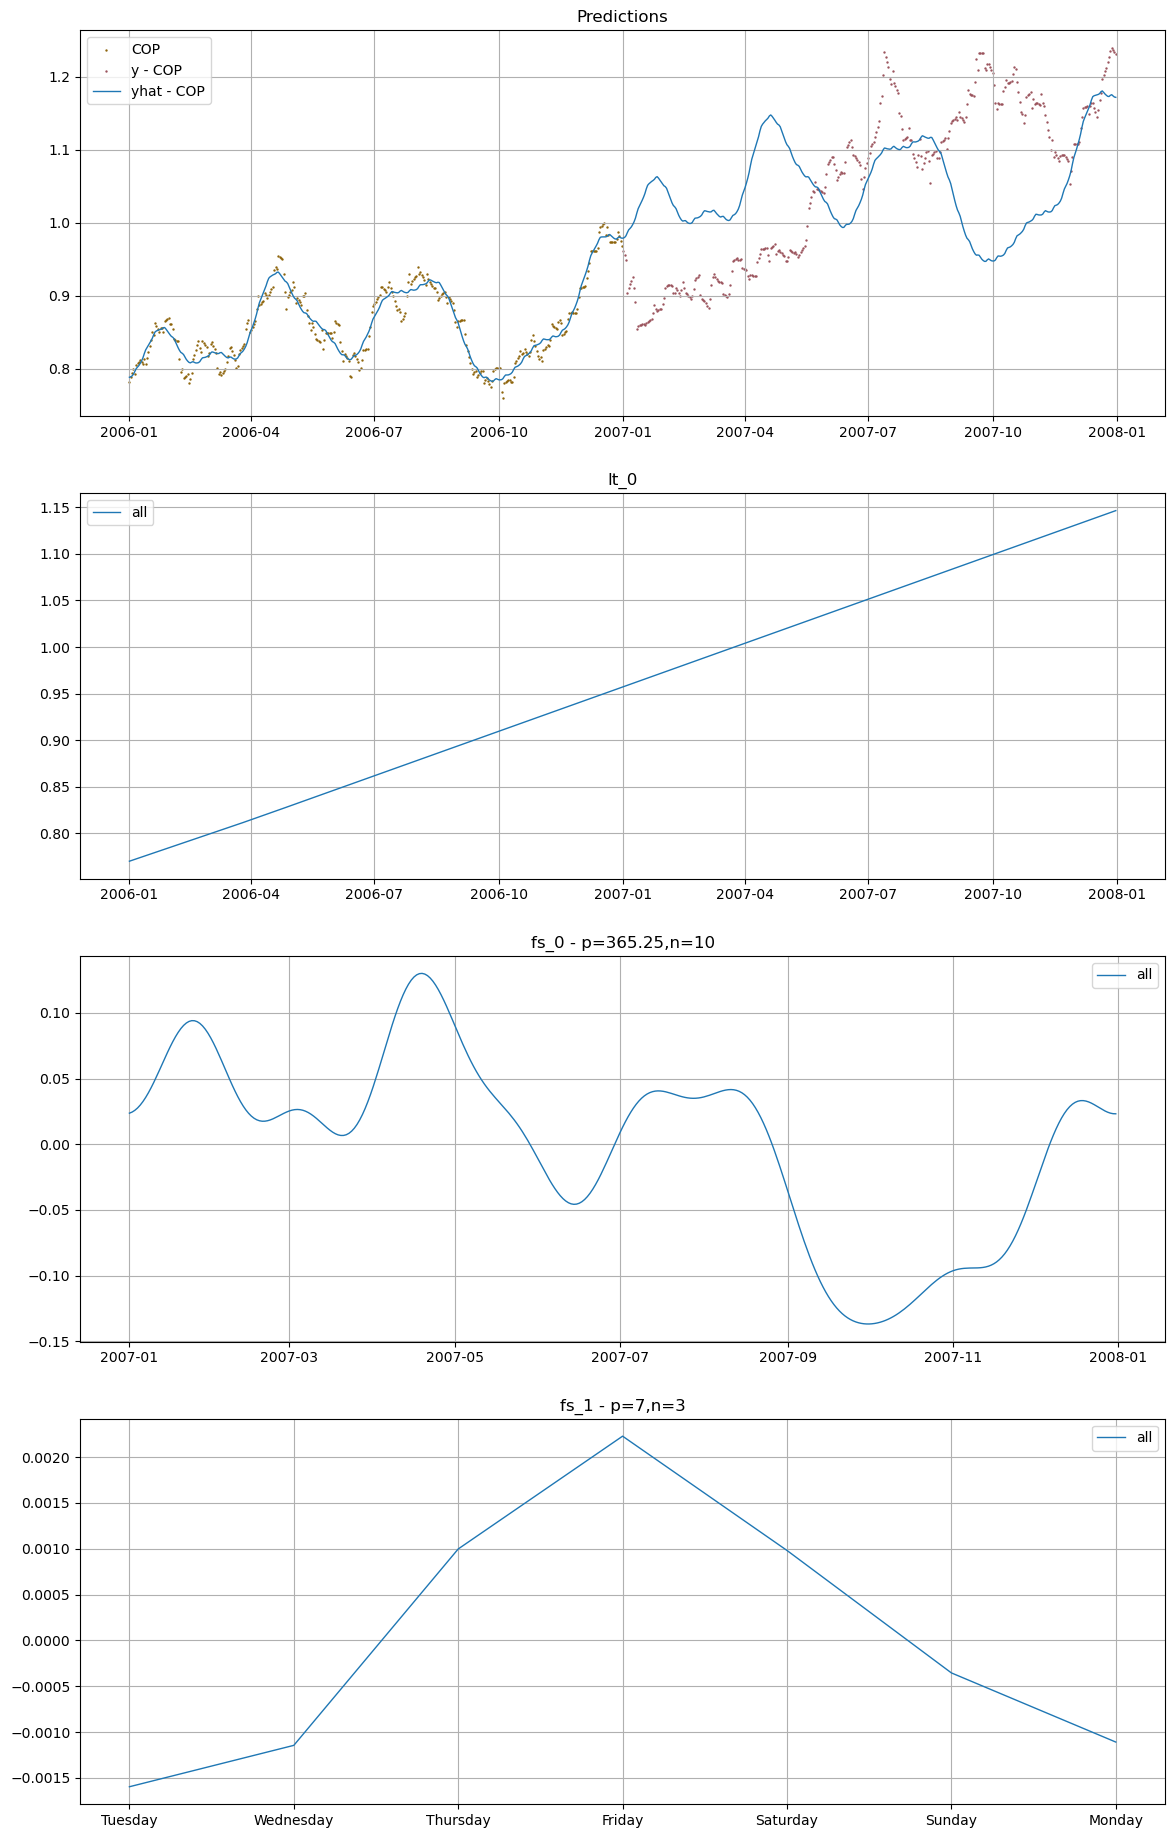

In [122]:
model.plot(yhat, test_df_tickers, pool_cols="series")

Output()

0.10014841179040156


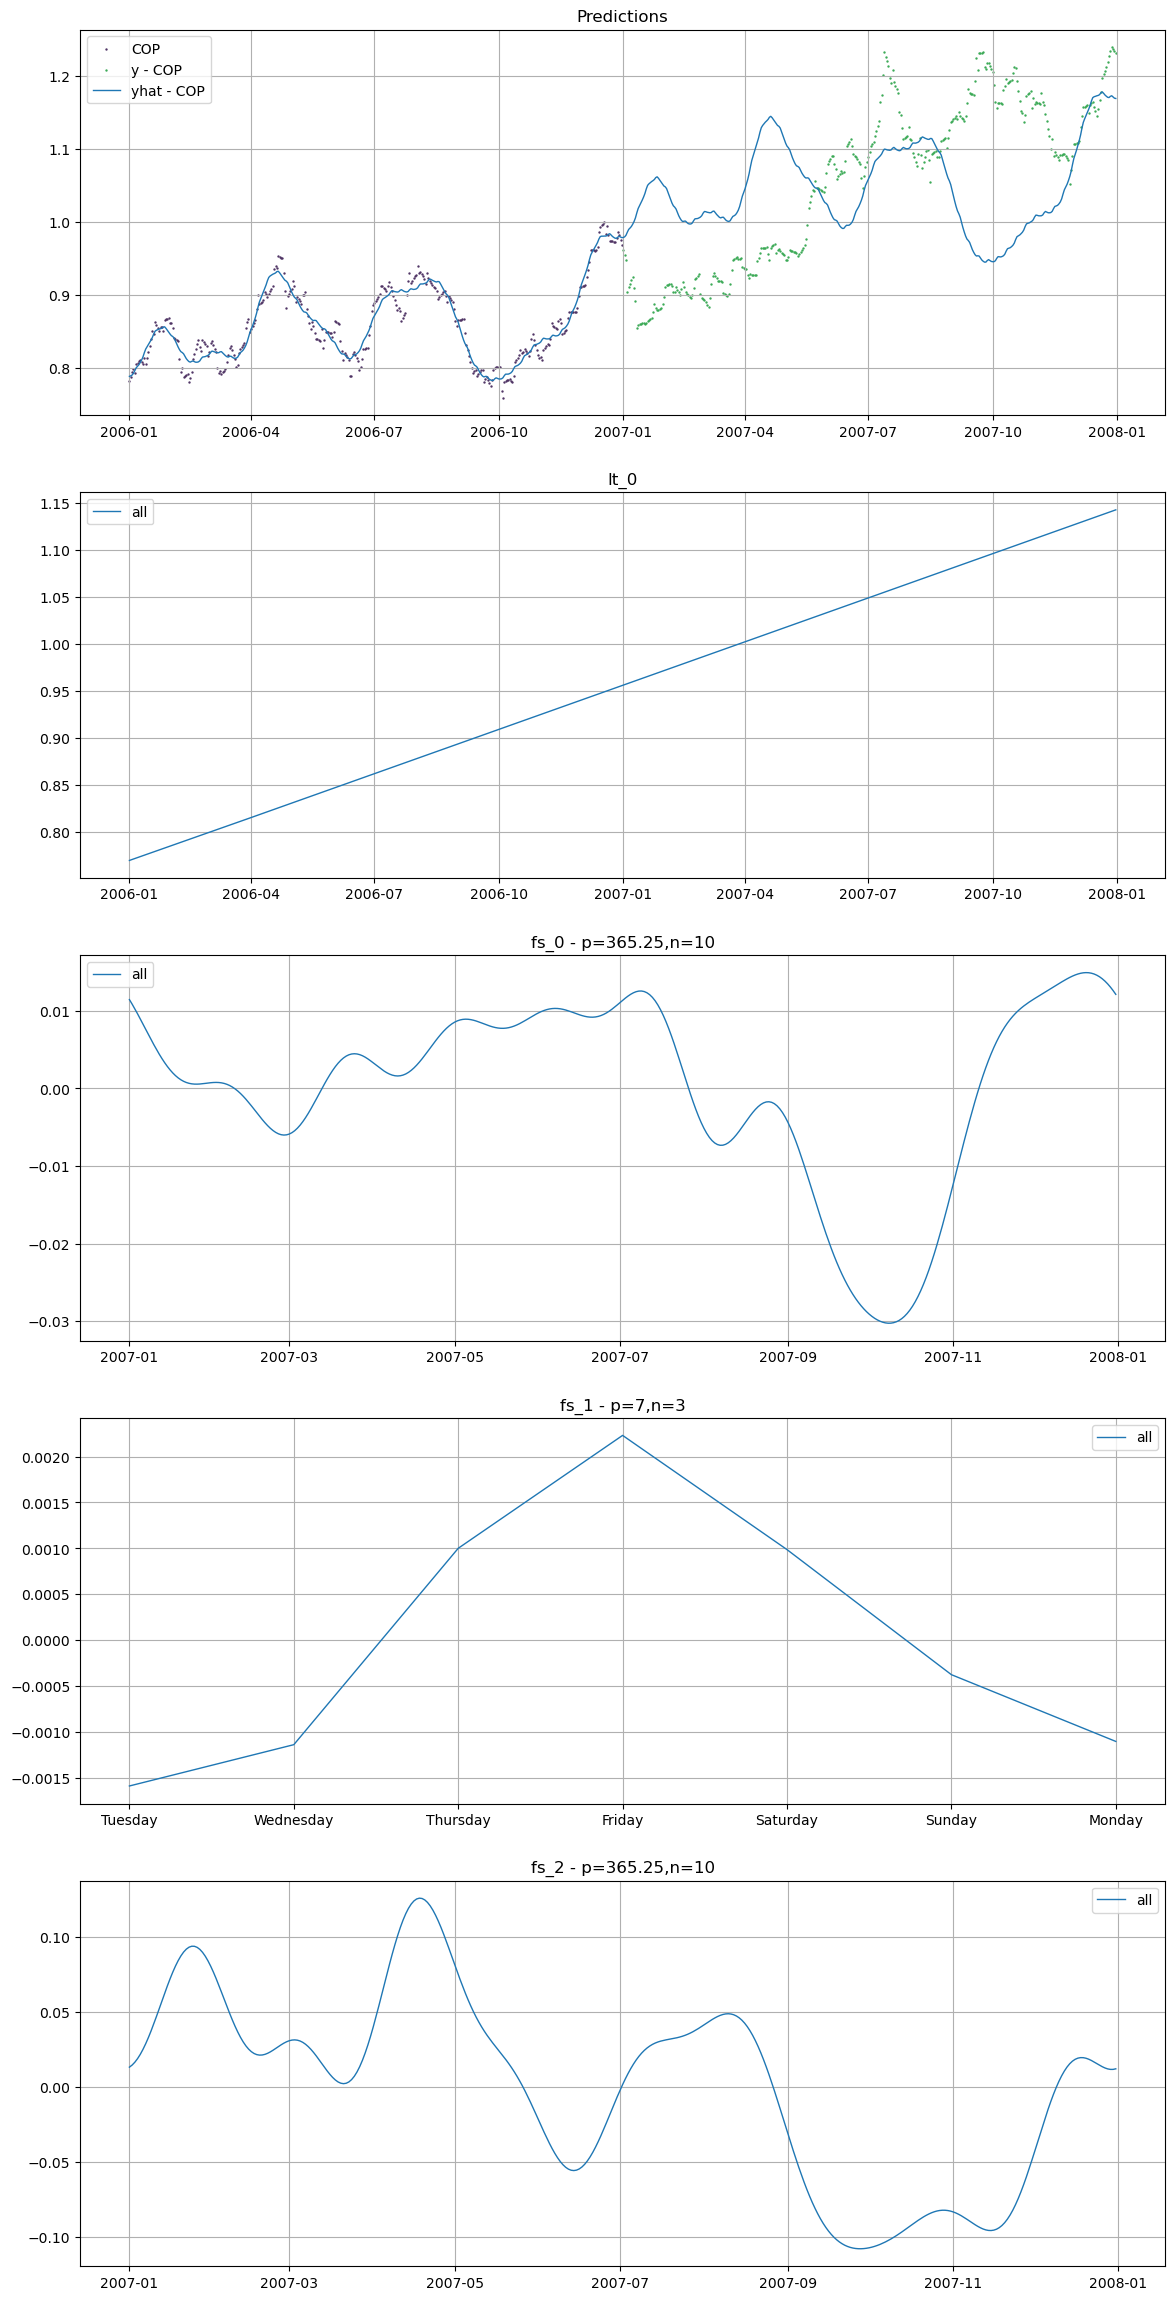

In [224]:
model = LinearTrend(n_changepoints=25, changepoint_range=0.8) * (
    FourierSeasonality(365.25, 10, allow_tune=True)
    + FourierSeasonality(7, 3, allow_tune=False)
)
point = "2007-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
)
model.fit(train_df_smp, progressbar=True)

check = generate_train_test_df_around_point(
    window=365,
    horizon=365,
    dfs=[smp_tickers[-1]],
    for_prophet=False,
    point=point,
)
if check is None:
    print("No")

train_df_tickers, test_df_tickers, scales_tickers = check
# model.left.n_changepoints = 5
# model.left.changepoint_range = 0.5
model.right += FourierSeasonality(365.25, 10, allow_tune=False) 
model.tune(train_df_tickers, progressbar=False)
yhat = model.predict(365)
print(model.metrics(test_df_tickers, yhat, pool_cols="series")["mape"].iloc[0])
model.plot(yhat, test_df_tickers, pool_cols="series")

In [227]:
str(model.right)

'FS(p=365.25,n=10,at=True,complete) + FS(p=7,n=3,at=False,complete) + FS(p=365.25,n=10,at=False,complete)'

In [223]:
pd.concat(model_metrics)

,mse,rmse,mae,mape
^GSPC,0.002261,0.047553,0.037040,0.035636
UDR,0.128342,0.358248,0.308496,0.411833
ATO,0.024040,0.155048,0.112594,0.127745
KR,0.025236,0.158860,0.132305,0.112855
DOV,0.018703,0.136757,0.122965,0.129269
...,...,...,...,...
XRX,0.014467,0.120277,0.097402,0.095490
RF,0.057269,0.239310,0.190618,0.247085
AES,0.040411,0.201024,0.161679,0.187666
MCHP,0.008997,0.094854,0.079321,0.081069


In [209]:
model.map_approx['fs_0 - beta(p=365.25,n=10)'].shape

(1, 20)

In [70]:
def run_test_2(idx, point):
    train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
        window=365 * 35, horizon=365, dfs=smp, for_prophet=False, point=point
    )
    model = final_models[idx]
    model.fit(train_df_smp, progressbar=False)
    map_approx = model.map_approx
    model_metrics = []

    check = generate_train_test_df_around_point(
        window=365 * 1,
        horizon=365,
        dfs=smp + smp_tickers[::4],
        for_prophet=False,
        point=point,
    )

    train_df_tickers, test_df_tickers, scales_tickers = check
    model.map_approx = map_approx
    model.tune(train_df_tickers, progressbar=True)
    yhat = model.predict(365)
    yhat.to_csv(f"./out/single_model_{idx}.csv")
    model_metrics = model.metrics(test_df_tickers, yhat, pool_cols="series")

    print(f"{idx} - {model}: {model_metrics['mape'].mean()}")
    return model_metrics